# Test model

In [1]:
#hide_input
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lightgbm import LGBMRegressor


def normalize_features(X):
    """Normalisation robuste des features"""
    X_normalized = X.copy()
    for col in X_normalized.columns:
        X_normalized[col] = pd.to_numeric(X_normalized[col], errors='coerce')
        q1, q99 = X_normalized[col].quantile([0.01, 0.99])
        X_normalized[col] = X_normalized[col].clip(q1, q99)
        mean = X_normalized[col].mean()
        std = X_normalized[col].std()
        if std != 0:
            X_normalized[col] = (X_normalized[col] - mean) / std
        else:
            X_normalized[col] = 0
    return X_normalized

def preprocess_data(df):
    """Prétraitement complet des données"""
    # Copie et nettoyage initial
    df = df.copy()
    
    # Gestion des NaN
    nan_ratio = df.isna().sum() / len(df)
    columns_to_drop = nan_ratio[nan_ratio > 0.5].index
    df = df.drop(columns=columns_to_drop)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median())
    
    # Séparation features/target
    y = df['RT']
    X = df.drop(['Molecule_Name', 'RT'], axis=1)
    initial_features = X.shape[1]
    
    # Filtrage variance
    selector = VarianceThreshold(threshold=0.01)
    X_var = pd.DataFrame(selector.fit_transform(X), 
                        columns=X.columns[selector.get_support()])
    
    # Normalisation
    X_scaled = normalize_features(X_var)
    
    # Suppression corrélations
    corr_matrix = X_scaled.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X_scaled = X_scaled.drop(to_drop, axis=1)
    
    return X_scaled.astype(np.float32), y, initial_features

def get_models():
    """Retourne les modèles à évaluer"""
    return {
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'LightGBM': LGBMRegressor(
            random_state=42,
            verbose=-1,  # Supprime tous les warnings
            min_child_samples=5,  # Minimum d'échantillons requis pour un nœud feuille
            min_data_in_leaf=5,  # Même chose que min_child_samples
            min_gain_to_split=0  # Gain minimum requis pour faire un split
        ),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }


Résultats pour Combined_pca (n_features=116):
--------------------------------------------------
Ridge           - CV R²: -0.132 (±0.297), Test R²: -4.077
Lasso           - CV R²: 0.182 (±0.043), Test R²: -0.054
RandomForest    - CV R²: 0.336 (±0.106), Test R²: -0.079
GradientBoosting - CV R²: 0.399 (±0.148), Test R²: -0.608
ExtraTrees      - CV R²: 0.402 (±0.092), Test R²: 0.011
XGBoost         - CV R²: 0.215 (±0.164), Test R²: -0.677
LightGBM        - CV R²: 0.271 (±0.218), Test R²: -0.464
SVR             - CV R²: 0.080 (±0.029), Test R²: -0.283
KNN             - CV R²: 0.159 (±0.046), Test R²: -0.637

Résultats pour ECFP_pca (n_features=125):
--------------------------------------------------
Ridge           - CV R²: -2.588 (±0.772), Test R²: -11.849
Lasso           - CV R²: -0.002 (±0.031), Test R²: -0.317
RandomForest    - CV R²: 0.202 (±0.065), Test R²: -0.067
GradientBoosting - CV R²: 0.151 (±0.192), Test R²: -0.039
ExtraTrees      - CV R²: 0.172 (±0.099), Test R²: -0.279
XGBoo

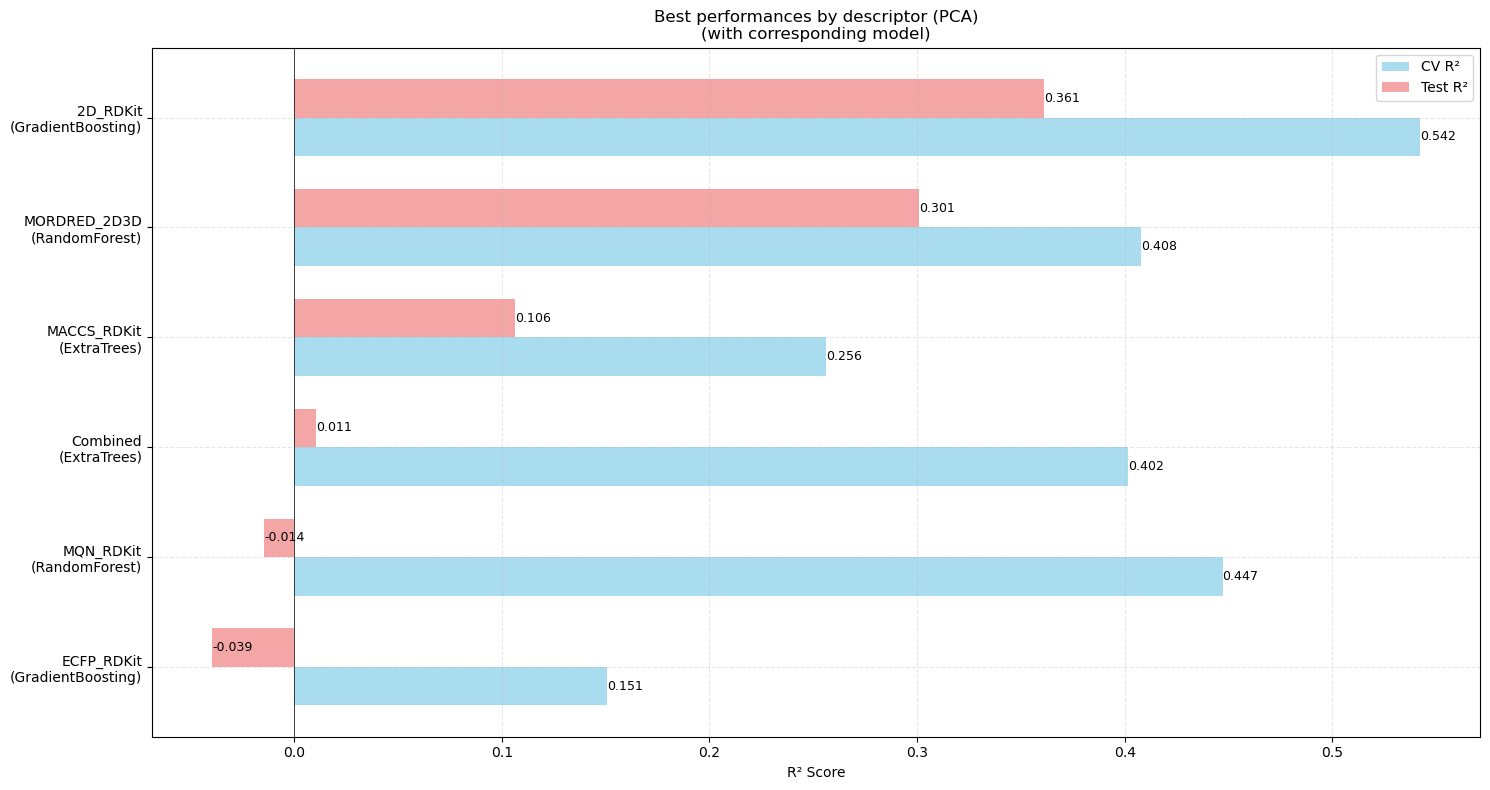


Meilleures performances CV:
           Descriptor             Model     CV_R2   Test_R2
49       RDKit_2D_pca        ExtraTrees  0.552825  0.157854
48       RDKit_2D_pca  GradientBoosting  0.541967  0.360944
40  Mordred_2D_3D_pca        ExtraTrees  0.494833  0.241750
31            MQN_pca        ExtraTrees  0.480883 -0.150854
30            MQN_pca  GradientBoosting  0.472642 -0.229452

Meilleures performances Test:
           Descriptor             Model     CV_R2   Test_R2
48       RDKit_2D_pca  GradientBoosting  0.541967  0.360944
38  Mordred_2D_3D_pca      RandomForest  0.407850  0.301153
51       RDKit_2D_pca          LightGBM  0.427090  0.246373
40  Mordred_2D_3D_pca        ExtraTrees  0.494833  0.241750
39  Mordred_2D_3D_pca  GradientBoosting  0.425599  0.232880


In [4]:
def evaluate_models(X, y, dataset_name):
    """Évalue tous les modèles sur un dataset"""
    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = {}
    print(f"\nRésultats pour {dataset_name} (n_features={X.shape[1]}):")
    print("-" * 50)
    
    for model_name, model in get_models().items():
        try:
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
            
            # Test set
            model.fit(X_train, y_train)
            test_score = model.score(X_test, y_test)
            
            results[model_name] = {
                'cv_r2_mean': cv_scores.mean(),
                'cv_r2_std': cv_scores.std(),
                'test_r2': test_score
            }
            
            print(f"{model_name:15} - CV R²: {cv_scores.mean():.3f} (±{cv_scores.std():.3f}), Test R²: {test_score:.3f}")
            
        except Exception as e:
            results[model_name] = {
                'cv_r2_mean': np.nan,
                'cv_r2_std': np.nan,
                'test_r2': np.nan
            }
            print(f"Erreur avec {model_name}: {str(e)}")
    
    return results


# Chargement et évaluation des données
data_dir = 'data/feature_selection/unsupervised/'
datasets = {
    'Combined_pca': 'Combined_pca.parquet',
    'ECFP_pca': 'ECFP_pca.parquet',
    'MACCS_pca': 'MACCS_pca.parquet',
    'MQN_pca': 'MQN_pca.parquet',
    'Mordred_2D_3D_pca': 'Mordred_2D_3D_pca.parquet',
    'RDKit_2D_pca': 'RDKit_2D_pca.parquet'
}

def preprocess_data_pca(df):
    """Prétraitement pour les données PCA"""
    # Séparation features/target
    y = df['RT']
    X = df.drop(['RT'], axis=1)  # On enlève juste RT, pas Molecule_Name
    initial_features = X.shape[1]
    
    # Normalisation
    X_scaled = normalize_features(X)
    
    return X_scaled.astype(np.float32), y, initial_features

results = {}

for dataset_name, filename in datasets.items():
    try:
        df = pd.read_parquet(f'{data_dir}/{filename}')
        X_scaled, y, n_features = preprocess_data_pca(df)
        
        results[dataset_name] = evaluate_models(X_scaled, y, dataset_name)
        
    except Exception as e:
        print(f"Error processing {dataset_name}: {str(e)}")

# Création du DataFrame de résultats
summary_data = []
for dataset_name, models_results in results.items():
    for model_name, scores in models_results.items():
        summary_data.append({
            'Descriptor': dataset_name,  # Changed from 'Dataset' to 'Descriptor'
            'Model': model_name,
            'CV_R2': scores['cv_r2_mean'],
            'Test_R2': scores['test_r2']
        })

summary_df = pd.DataFrame(summary_data)

def plot_results(summary_df):
    """Synthetic visualization of best performances by descriptor"""
    os.makedirs('figures/pca', exist_ok=True)
    
    plt.figure(figsize=(15, 8))
    
    # Rename descriptors
    descriptor_mapping = {
        'Combined_pca': 'Combined',
        'ECFP_pca': 'ECFP_RDKit',
        'MACCS_pca': 'MACCS_RDKit',
        'MQN_pca': 'MQN_RDKit',
        'Mordred_2D_3D_pca': 'MORDRED_2D3D',
        'RDKit_2D_pca': '2D_RDKit'
    }
    
    # Create a copy and map new names
    df_plot = summary_df.copy()
    df_plot['Descriptor'] = df_plot['Descriptor'].map(descriptor_mapping)
    
    # Calculate best performances
    best_performances = (df_plot
        .sort_values('Test_R2', ascending=False)
        .groupby('Descriptor')
        .agg({
            'Model': 'first',
            'Test_R2': 'max',
            'CV_R2': 'first'
        })
        .reset_index())
    
    # Sort by test performance
    best_performances = best_performances.sort_values('Test_R2', ascending=True)
    
    # Bar positions
    y_pos = np.arange(len(best_performances))
    width = 0.35
    
    # Create horizontal bars
    plt.barh(y_pos - width/2, best_performances['CV_R2'], width, 
             label='CV R²', color='skyblue', alpha=0.7)
    plt.barh(y_pos + width/2, best_performances['Test_R2'], width, 
             label='Test R²', color='lightcoral', alpha=0.7)
    
    # Add labels
    plt.yticks(y_pos, [f"{d}\n({m})" for d, m in zip(best_performances['Descriptor'], 
                                                     best_performances['Model'])])
    
    # Customize plot
    plt.xlabel('R² Score')
    plt.title('Best performances by descriptor (PCA)\n(with corresponding model)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add values on bars
    for i, (cv, test) in enumerate(zip(best_performances['CV_R2'], best_performances['Test_R2'])):
        plt.text(cv, i - width/2, f'{cv:.3f}', va='center', ha='left', fontsize=9)
        plt.text(test, i + width/2, f'{test:.3f}', va='center', ha='left', fontsize=9)
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    # Sauvegarder la figure
    plt.savefig('figures/pca/best_performances.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# Affichage des résultats
plot_results(summary_df)

# Meilleures performances
print("\nMeilleures performances CV:")
print(summary_df.nlargest(5, 'CV_R2')[['Descriptor', 'Model', 'CV_R2', 'Test_R2']])

print("\nMeilleures performances Test:")
print(summary_df.nlargest(5, 'Test_R2')[['Descriptor', 'Model', 'CV_R2', 'Test_R2']])

# Sauvegarde des résultats
summary_df.to_csv('data/results/performance_summary_pca.csv', index=False)